-------------------------------------------------

This notebook is part of the [q4p (Quantum Computing for Programmers) series](https://github.com/CarloLepelaars/q4p). The original notebook can be found on [Github](https://github.com/CarloLepelaars/q4p/blob/main/nbs/02-gates.ipynb).

-------------------------------------------------

# 2. Quantum Logic Gates

In this lesson you will learn:

- What are quantum logic gates and its requirements?
- **Pauli Gates**
- The **Clifford Group**
- The $CNOT$ Multi-Qubit Gate
- The "odd duck" $T$ Gate
- BONUS: Generalized rotation gates

## What are quantum gates?

In [notebook 1](https://github.com/CarloLepelaars/q4p/blob/main/nbs/01-the-qubit.ipynb) we have described the foundation of quantum computing as a state evolving through a series of quantum logic gates. We have also discussed one of the simplest meaningful logic gates called the $X$ (NOT) gate. Here we will discuss the foundation of these gates and the most common implementations. We will start with a single qubit and then move on to multi-qubit gates.


Recall that a quantum state for a single qubit is a vector with 2 complex numbers. Almost all quantum algorithms start with the zero state:

$$
\begin{bmatrix}
1 \\
0
\end{bmatrix} = |0\rangle
$$

## skq

To avoid having to construct gates and concepts from scratch each time we will use the [skq](https://github.com/CarloLepelaars/skq) library. I built this library so you can easily play with quantum concepts in NumPy and build your own algorithms. These circuits can then be converted to popular quantum frameworks like [Qiskit](https://github.com/Qiskit/qiskit) and [OpenQASM](https://openqasm.com/intro.html) so you can run them on real quantum computers.

In [1]:
# skq is used for quantum gates and circuits
!pip install -Uqq skq

In [2]:
import numpy as np

from skq.circuits import Circuit
from skq.gates.qubit import X, Y, Z, I, H, S, T, CX, RX, RY, RZ, R

In [3]:
zero_state = np.array([1, 0], dtype=complex)
zero_state

array([1.+0.j, 0.+0.j])

## Pauli Gates

The $X$ (NOT) gate discussed in notebook 1 is one of the fundamental Pauli Gates. The Pauli Gates are special in quantum computing as they are all "observables", which means they can be used for measuring a qubit. For completeness we also define an Identity gate ($I$), which does not change the state. The Pauli Gates and Identity gate can be described as matrices:

$$
X = \sigma_x = \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix},
\quad
Y = \sigma_y = \begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix},
\quad
Z = \sigma_z = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix},
\quad
I = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$


In [4]:
X()

X([[0.+0.j, 1.+0.j],
   [1.+0.j, 0.+0.j]])

Each gate can also be visualized in a circuit diagram. We will heavily use these visualizations to understand quantum circuits.

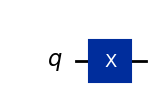

In [5]:
X().draw(output="mpl")

In [6]:
Y()

Y([[ 0.+0.j, -0.-1.j],
   [ 0.+1.j,  0.+0.j]])

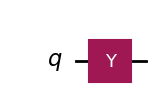

In [7]:
Y().draw(output="mpl")

In [8]:
Z()

Z([[ 1.+0.j,  0.+0.j],
   [ 0.+0.j, -1.+0.j]])

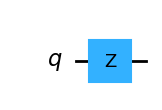

In [9]:
Z().draw(output="mpl")

In [10]:
I()

I([[1.+0.j, 0.+0.j],
   [0.+0.j, 1.+0.j]])

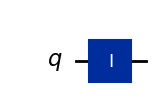

In [11]:
I().draw(output="mpl")

Rotating $| 0 \rangle$ around the Y-axis ($Y|0\rangle$) gives us the state $i|1\rangle$:

In [12]:
Y() @ zero_state

Y([0.+0.j, 0.+1.j])

Certain states are not affected by rotation around an axis, because they are already aligned with that axis. Rotating $| 0 \rangle$ or $| 1 \rangle$ around the Z-axis ($Z|0\rangle$) does not change the state.

In [13]:
Z() @ zero_state

Z([1.+0.j, 0.+0.j])

The $Z$ is also called the phase-flip gate. It flips the $|1\rangle$ part of the superposition state $|+ \rangle$, resulting in the state $|-\rangle$:

$$Z |+ \rangle = Z \left( \begin{bmatrix}
\frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}}
\end{bmatrix} \right) = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix} \begin{bmatrix}
\frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}}
\end{bmatrix} = \begin{bmatrix}
\frac{1}{\sqrt{2}} \\
-\frac{1}{\sqrt{2}}
\end{bmatrix} = |-\rangle
$$

In [14]:
Z() @ np.array([1 / np.sqrt(2), 
                1 / np.sqrt(2)])

Z([ 0.70710678+0.j, -0.70710678+0.j])

The identity gate will return the state unchanged:

In [15]:
I() @ zero_state

I([1.+0.j, 0.+0.j])

# Requirements of quantum logic gates

The main requirement for a quantum logic gates is that the matrix must be unitary. This means that if multiply the matrix ($U$) by its conjugate transpose ($U^\dagger$), we should get the identity matrix ($I$). Recall that the conjugate transpose is just flipping the complex part of the numbers and transposing it. For any valid quantum gate $U$ it should hold that:

$$
U U^\dagger = I
$$



Let's take for example the Y-gate:

$$
Y = \begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix}
$$

$$
Y^\dagger = \begin{bmatrix}
0 & i \\
-i & 0
\end{bmatrix}
$$

$$
Y Y^\dagger = \begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix} \begin{bmatrix}
0 & i \\
-i & 0
\end{bmatrix} = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix} = I
$$


In [16]:
y_mul = Y() @ Y().conj().T
y_mul

Y([[1.+0.j, 0.+0.j],
   [0.+0.j, 1.+0.j]])

In [17]:
np.allclose(y_mul, I())

True

Another way to frame this requirement is that the computation of evolving a state through a gate must be reversible. If we first apply a gate and then the conjugate transpose of that gate, we get back the original state. 

To evolve a state through a gate we perform a vector-matrix multiplication with `@`. To get back the original state we apply the conjugate transpose of the gate (`gate.conj().T`) with `@`. We can also use `decodes` on `skq` gates to apply the conjugate transpose.

This allow us to conveniently create gates and use them as blocks to build a circuit.

In [18]:
x_gate, y_gate, z_gate = X(), Y(), Z()
x_gate(zero_state)

array([0.+0.j, 1.+0.j])

In [19]:
x_gate.decodes(x_gate(zero_state))

array([1.+0.j, 0.+0.j])

To run circuits in sequence we can use the `Circuit` class that applies multiple gates. This is a simple object that can run the gates, but also visualize them and convert to other quantum frameworks.

In [20]:
pipe = Circuit([y_gate, z_gate])

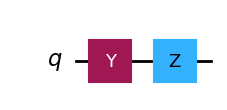

In [21]:
pipe.draw(output="mpl")

This is our first quantum circuit with multiple different gates. This circuit first flip the state around the Y-axis and then around the Z-axis.

$$
|0\rangle \rightarrow Y \rightarrow Z \rightarrow -i |1\rangle
$$

$$
|0\rangle = \begin{bmatrix}
1 \\
0
\end{bmatrix}
$$

$$
Y |0\rangle = \begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix} \begin{bmatrix}
1 \\
0
\end{bmatrix} = \begin{bmatrix}
0 \\
i
\end{bmatrix}
$$

$$
Z (Y |0\rangle) = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix} \begin{bmatrix}
0 \\
i
\end{bmatrix} = \begin{bmatrix}
0 \\
-i
\end{bmatrix} = -i |1\rangle
$$

In [22]:
# Z @ Y @ |0>
output_state = pipe(zero_state)
output_state

array([0.+0.j, 0.-1.j])

The decoding is computed as follows:

$$
-i|1\rangle \rightarrow Z^\dagger \rightarrow Y^\dagger \rightarrow |0\rangle
$$

$$
Z^\dagger | \Psi \rangle = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix} \begin{bmatrix}
0 \\
-i
\end{bmatrix} = \begin{bmatrix}
0 \\
i
\end{bmatrix}
$$

$$
Y^\dagger (Z^\dagger | \Psi \rangle) = \begin{bmatrix}
0 & i \\
-i & 0
\end{bmatrix} \begin{bmatrix}
0 \\
i
\end{bmatrix} = \begin{bmatrix}
1 \\
0
\end{bmatrix} = |0\rangle
$$

In [23]:
# Decoding output yields back the original state
pipe.decodes(output_state)

array([1.+0.j, 0.+0.j])

Now we can easily evolve a state through multiple gates. One of the few gaps keeping us from building serious quantum algorithms is the generalization to multiple qubits. The generalization of quantum gates to multiple qubits is discussed in-depth in the next notebook, but we will discuss one important multi-qubit gate in this notebook.

## Clifford Group

The Clifford group is a set of common logic gates that are available on any modern quantum computer. These are the fundamental building blocks for many quantum algorithms. Most quantum error correction schemes focus on the Clifford group. The Pauli gates are part of the Clifford group in addition to the Hadamard ($H$) gate, $S$ gate and $CX$ gate. 

Formally, a Clifford gate is any gate that transforms Pauli gates into other Pauli gates. When we apply a Clifford gate $C$ to a Pauli gate $P$ in the following way:

$$
C P C^\dagger
$$

The result must be another Pauli gate.

For example, let's take the Hadamard gate $H$ as our Clifford gate and see how it transforms the Pauli $X$ gate:

$$
H = \frac{1}{\sqrt{2}}\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}, \quad
X = \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}, \quad
H^\dagger = H
$$

$$
H X H = \frac{1}{\sqrt{2}}\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix} \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix} \frac{1}{\sqrt{2}}\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix} = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix} = Z
$$

Therefore, the Hadamard gate transforms the Pauli $X$ gate into the Pauli $Z$ gate, confirming that $H$ is a Clifford gate.

In [24]:
# HXH -> Z. Therefore H is a Clifford gate
np.array(H() @ X() @ H().conj().T).round()

array([[ 1.+0.j, -0.+0.j],
       [ 0.+0.j, -1.+0.j]])

Similarly, $H Z H = X$.

In [25]:
# HZH -> X. Therefore H is a Clifford gate
np.array(H() @ Z() @ H().conj().T).round()

array([[-0.+0.j,  1.+0.j],
       [ 1.+0.j, -0.+0.j]])

This property makes Clifford gates particularly useful for quantum error correction and many quantum algorithms, though they are not sufficient for universal quantum computation on their own. These are all the gates in the Clifford group:

$$
X = \sigma_x = \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix},
\quad
Y = \sigma_y = \begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix},
\quad
Z = \sigma_z = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix},
\quad
I = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
H = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}, \quad
S = \begin{bmatrix}
1 & 0 \\
0 & i
\end{bmatrix}, \quad
CX = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{bmatrix}
$$

We will now go over them one by one.

### $H$ (Hadamard) Gate
The $H$ (Hadamard) gate is an essential gate in quantum computing. It puts qubits in superposition. The reason why this is important is that it is often the 1st step in many quantum algorithms. Very often all qubits are converted into a superposition state, so we can leverage the power of quantum interference. These interference patterns are essential for quantum parallelism.

$$
H = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}
$$


In [26]:
H()

H([[ 0.70710678+0.j,  0.70710678+0.j],
   [ 0.70710678+0.j, -0.70710678+0.j]])

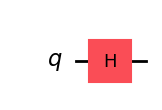

In [27]:
H().draw(output="mpl")

In [28]:
H()(zero_state)

array([0.70710678+0.j, 0.70710678+0.j])

This gate allows you to convert $|0\rangle \rightarrow \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)$ (i.e. fair coin flip). 

$$
H |0\rangle = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix} \begin{bmatrix}
1 \\
0
\end{bmatrix} = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 \\
1
\end{bmatrix} = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)
$$

Obtaining measurement probabilities with `abs(state)**2`:

$$
\left|\frac{1}{\sqrt{2}} \begin{bmatrix}
1 \\
1
\end{bmatrix}\right|^2 = \begin{bmatrix}
\frac{1}{2} \\
\frac{1}{2}
\end{bmatrix}
$$

In [29]:
# Probabilities for H|0> are a fair coin flip
np.abs(H()(zero_state)**2)

array([0.5, 0.5])

### $S$ Gate

The $S$ gate is similar to the $Z$ gate in that it is a phase-shift gate. In fact, it is the square root of the $Z$ gate.

$$
S = \begin{bmatrix}
1 & 0 \\
0 & i
\end{bmatrix}
$$

The equivalence of $S$ with the square root of $Z$ arises from the definition of the imaginary unit, which is $\sqrt{-1} = i$.

$$
\sqrt{Z} = \sqrt{\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}} = \begin{bmatrix}
1 & 0 \\
0 & \sqrt{-1}
\end{bmatrix} = \begin{bmatrix}
1 & 0 \\
0 & i
\end{bmatrix} = S
$$



In [30]:
S()

S([[1.000000e+00+0.j, 0.000000e+00+0.j],
   [0.000000e+00+0.j, 6.123234e-17+1.j]])

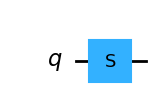

In [31]:
S().draw(output="mpl")

As with the $Z$ gate, the $S$ gate has no effect on the $|0\rangle$ state.

In [32]:
S()(zero_state)

array([1.+0.j, 0.+0.j])

It transforms the superposition state $|+ \rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle$ into the state $|i\rangle$ as follows:

$$S |+ \rangle = 
S \begin{bmatrix}
\frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}}
\end{bmatrix} = \begin{bmatrix}
1 & 0 \\
0 & i
\end{bmatrix} \begin{bmatrix}
\frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}}
\end{bmatrix} = \begin{bmatrix}
\frac{1}{\sqrt{2}} \\
\frac{i}{\sqrt{2}}
\end{bmatrix} = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 \\
i
\end{bmatrix} = \frac{1}{\sqrt{2}} (|0\rangle + i|1\rangle) = |i\rangle
$$

In other words, the real $|1\rangle$ part of the state is transferred to the imaginary part $i|1\rangle$.

In [33]:
S()(np.array([1 / np.sqrt(2), 
              1 / np.sqrt(2)]))

array([7.07106781e-01+0.j        , 4.32978028e-17+0.70710678j])

### $CX$ (CNOT) Gate

The last gate in the Clifford group is the $CX$ ($CNOT$) gate. This is the first multi-qubit gate we are encountering. Instead of a $2 \times 2$ single qubit gate, a gate for $2$ qubits is described by a $4 \times 4$ matrix. More generally, a gate for $n$ qubits is described by a $2^n \times 2^n$ matrix.

The $CX$ gate flips the 2nd qubit based on the state of the 1st qubit. If the 1st qubit is $|1\rangle$ the 2nd qubit is flipped along the X-axis. This gate enables (controlled) quantum entanglement and is something that isn't available on classical computers.

The $CX$ ($CNOT$) gate is described as follows:
$$
CX = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{bmatrix}
$$

In order to demonstrate this gate, we need to construct a 2-qubit state. Let us briefly discuss what a multi-qubit state signifies. A state of $n$ qubits is a vector with $2^n$ complex numbers, so for 2 qubits we need a vector with 4 complex numbers.

The two-qubit $|00\rangle$ state is:

$$
|00\rangle = \begin{bmatrix}
1 \\
0 \\
0 \\
0
\end{bmatrix} = 1|00\rangle + 0|01\rangle + 0|10\rangle + 0|11\rangle
$$

The $|11\rangle$ state is:

$$
|11\rangle = \begin{bmatrix}
0 \\
0 \\
0 \\
1
\end{bmatrix} = 0|00\rangle + 0|01\rangle + 0|10\rangle + 1|11\rangle
$$

The entangled state $\frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$:

$$
\frac{1}{\sqrt{2}} \begin{bmatrix}
1 \\
0 \\
0 \\
1
\end{bmatrix} = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
$$

It is important to see that the 2-qubit is a single entity. Unlike classical bits where all bits are treating independently, the 2-qubit state can be entangled and the single qubits can not longer be described independently.

Some 2-qubit states can be constructed from single qubits. For example, the $|11\rangle$ state. This is achieved through the tensor product ($\otimes$, i.e. Kronecker product). The tensor product is an essential tool for describing multi-qubit operations. To become familiar with it, I would recommend reading [this great blog post on the tensor product](https://www.math3ma.com/blog/the-tensor-product-demystified).

$$
|1\rangle \otimes |1\rangle = \begin{bmatrix}
0 \\
1
\end{bmatrix} \otimes \begin{bmatrix}
0 \\
1
\end{bmatrix} = \begin{bmatrix}
0 \\
0 \\
0 \\
1
\end{bmatrix} = |11\rangle
$$

In [34]:
one_state = np.array([[0, 1]], dtype=complex)
np.kron(one_state, one_state)

array([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

Now notice the entangled state $\frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$. There is no way to construct this state from a tensor product of single qubits. This shows the qubits are not separable. Entangled states are not separable. Therefore, we can also not visualize the single qubits in the [bloch sphere](https://en.wikipedia.org/wiki/Bloch_sphere) anymore. We have to treat the 2-qubit state as a single thing. The $CX$ gate allows us to entangle qubits.

Let's first look at the $CX$'s behavior on its own. We will flip the state $|10\rangle$ to $|11\rangle$:

$$
CX |10\rangle = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{bmatrix} \begin{bmatrix}
0 \\
0 \\
1 \\
0
\end{bmatrix} = \begin{bmatrix}
0 \\
0 \\
0 \\
1
\end{bmatrix} = |11\rangle
$$

In [35]:
CX()

CX([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
    [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
    [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
    [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

The $CX$ gates acts on two qubits so its visualization in a diagram involves two qubits and has a connection between them.

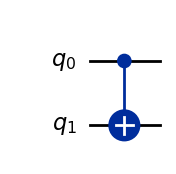

In [36]:
CX().draw(output="mpl")

In [37]:
# |10> -> |11>
one_zero_state = np.array([0, 0, 1, 0], dtype=complex)
CX()(one_zero_state)

array([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])

The next notebook wil focus entirely on multi-qubit operations. With the CNOT gate in our toolbox we basically have the building blocks for constructing almost all sophisticated quantum algorithms. Complicated multi-qubit gates can often be constructed from a combination of Clifford gates.

It is possible to construct conditional gates that flip the $Y$ axis ($CY$ gate) or $Z$ ($CZ$ gate) axis. Direct use of these gates is much less common because they can also be easily constructed from a combination of $CNOT$ and Pauli gates. $CY$ and $CZ$ gates are technically also part of the Clifford group.

### Clifford Recap

To recap, here is an overview of all the gates in the Clifford group:

$$
X = \sigma_x = \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix},
\quad
Y = \sigma_y = \begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix},
\quad
Z = \sigma_z = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix},
\quad
I = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
H = \frac{1}{\sqrt{2}} \begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}, \quad
S = \begin{bmatrix}
1 & 0 \\
0 & i
\end{bmatrix}, \quad
CX = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{bmatrix}
$$

These gates are essential in quantum computing and are the most common gates used in quantum algorithms. However, this set cannot approximate any state. There is one odd duck that allows us complete freedom to approximate any state, this is the $T$ gate.

## $T$ Gate

The $T$ gate is a **phase-shift gate** like the $Z$ and $S$ gate. It rotates the Z-axis by $\frac{\pi}{4}$. Confusingly, it is sometimes called the $\pi/8$ gate for historical reasons, so if you see that in the literature, think $T$ gate.

The $T$ gate can be described as follows:

$$
T = \begin{bmatrix}
1 & 0 \\
0 & e^{i\pi/4}
\end{bmatrix}
$$

This gate is very similar to the $S$ gate, especially if you are comfortable with imaginary numbers. The $T$ gate is equal to the square root of the $S$ gate.

$$
\sqrt{S} = \sqrt{\begin{bmatrix}
1 & 0 \\
0 & i
\end{bmatrix}} = \begin{bmatrix}
1 & 0 \\
0 & \sqrt{i}
\end{bmatrix} = \begin{bmatrix}
1 & 0 \\
0 & e^{i\pi/4}
\end{bmatrix} = T
$$

In [38]:
S().sqrt()

CustomQubitGate([[1.        +0.j        , 0.        +0.j        ],
                 [0.        +0.j        , 0.70710678+0.70710678j]])

In [39]:
T()

T([[1.        +0.j        , 0.        +0.j        ],
   [0.        +0.j        , 0.70710678+0.70710678j]])

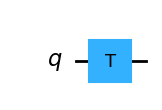

In [40]:
T().draw(output="mpl")

In [41]:
np.allclose(T(), S().sqrt())

True

In [42]:
T()([1/np.sqrt(2), 
     1/np.sqrt(2)])

array([0.70710678+0.j , 0.5       +0.5j])

The $T$ gate combined with the $H$ can be used to approximate any single qubit state. Combined with the $CNOT$ gate, we can approximate any multi-qubit state. So why do we need the other gates? First, restricting ourselves to these gates will make our algorithms complicated to implement and some states would take many $T$ and $H$ gates to approximate. Second, the $T$ gate can be harder to control physically compared to simpler gates like the Pauli gates. For many real quantum computers, the $T$ gate is not available natively so has to be decomposed from simpler gates. 

To get more experience I would recommend checking out [this interactive Bloch sphere](https://gallery.fastht.ml/app/visualizations/bloch_sphere) I made. It allows you to explore the Clifford group and the $T$ gate for a single qubit. Note that $H$ and $T$ gate combinations allow you to get into states that is not possible with only the Clifford gates. 

# BONUS: Generalized Rotation

It's important to reiterate that thinking about these gates as rotations is one of the most intuitive ways to understand them. We can formulate a general rotation gate to get to any state. These continuous rotation gates can be implemented on real quantum computers, but are generally harder to control compared to Clifford gates.

A general rotation for a single qubit is a combination of $X$, $Y$ and $Z$ gates. Let's define a gate for each axis and then combine them into one gate. Rotation in quantum computing is generally defined in [radians](https://en.wikipedia.org/wiki/Radian).


## $RX$ Gate

$$R_X(\theta) = \begin{bmatrix}
\cos(\frac{\theta}{2}) & -i\sin(\frac{\theta}{2}) \\
-i\sin(\frac{\theta}{2}) & \cos(\frac{\theta}{2})
\end{bmatrix}$$


$$RX(\frac{\pi}{2}) |0\rangle = \begin{bmatrix}
\cos(\frac{\pi}{4}) & -i\sin(\frac{\pi}{4}) \\
-i\sin(\frac{\pi}{4}) & \cos(\frac{\pi}{4})
\end{bmatrix} \begin{bmatrix}
1 \\
0
\end{bmatrix} = \begin{bmatrix}
\cos(\frac{\pi}{4}) \\
-i\sin(\frac{\pi}{4})
\end{bmatrix} = \cos(\frac{\pi}{4}) |0\rangle - i\sin(\frac{\pi}{4}) |1\rangle = \frac{1}{\sqrt{2}} (|0\rangle - i|1\rangle)$$


In [43]:
RX(np.pi / 2)

RX([[0.70710678+0.j        , 0.        -0.70710678j],
    [0.        -0.70710678j, 0.70710678+0.j        ]])

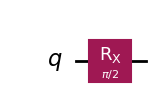

In [44]:
RX(np.pi / 2).draw(output="mpl")

In [45]:
RX(np.pi / 2) @ zero_state

RX([0.70710678+0.j        , 0.        -0.70710678j])

The Pauli $X$ gate is a special case of the $RX$ gate when $\theta = \pi$. This requires us to understand the concept of [global phase](https://physics.stackexchange.com/questions/401523/global-phases-and-indistinguishable-quantum-states-mathematical-understanding). Note that if we multiply a gate by a scalar (single number), its effect on states is the same. Therefore, some gates are mathematically equivalent if they are proportional ($\propto$) to each other. This is the trick we use to show the equivalence of $X$ gate and $RX(\pi)$.

$$RX(\pi) |0\rangle = \begin{bmatrix}
\cos(\frac{\pi}{2}) & -i\sin(\frac{\pi}{2}) \\
-i\sin(\frac{\pi}{2}) & \cos(\frac{\pi}{2})
\end{bmatrix} = \begin{bmatrix}
0 & -i \\
-i & 0
\end{bmatrix} \propto \begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix} = X$$

The same holds for the Pauli $Y$ and $Z$ gates. $RY(\pi) = Y$ and $RZ(\pi) = Z$.


## $RY$ Gate

$$R_Y(\theta) = \begin{bmatrix}
\cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2}) \\
\sin(\frac{\theta}{2}) & \cos(\frac{\theta}{2})
\end{bmatrix}$$

$$RY(\frac{\pi}{2}) |0\rangle = \begin{bmatrix}
\cos(\frac{\pi}{4}) & -\sin(\frac{\pi}{4}) \\
\sin(\frac{\pi}{4}) & \cos(\frac{\pi}{4})
\end{bmatrix} \begin{bmatrix}
1 \\
0
\end{bmatrix} = \begin{bmatrix}
\cos(\frac{\pi}{4}) \\
\sin(\frac{\pi}{4})
\end{bmatrix} = \cos(\frac{\pi}{4}) |0\rangle + \sin(\frac{\pi}{4}) |1\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle) = |+ \rangle$$


In [46]:
RY(np.pi / 2)

RY([[ 0.70710678+0.j, -0.70710678+0.j],
    [ 0.70710678+0.j,  0.70710678+0.j]])

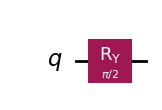

In [47]:
RY(np.pi / 2).draw(output="mpl")

In [48]:
RY(np.pi / 2) @ zero_state

RY([0.70710678+0.j, 0.70710678+0.j])

Even though $RY$ and Hadamard $H$ are 2 entirely different operations, we can see that if we start with the zero state $|0\rangle$, $H$ results in the same $|+ \rangle$ state as $RY(\pi/2)$. From other starting states they would be different.

## $RZ$ gate

$$R_Z(\theta) = \begin{bmatrix}
e^{-i\frac{\theta}{2}} & 0 \\
0 & e^{i\frac{\theta}{2}}
\end{bmatrix}$$

$$R_Z(\frac{\pi}{2}) |0\rangle = \begin{bmatrix}
e^{-i\frac{\pi}{4}} & 0 \\
0 & e^{i\frac{\pi}{4}}
\end{bmatrix} \begin{bmatrix}
1 \\
0
\end{bmatrix} = \begin{bmatrix}
e^{-i\frac{\pi}{4}} \\
0
\end{bmatrix} = e^{-i\frac{\pi}{4}} |0\rangle$$


In [49]:
RZ(np.pi / 2)

RZ([[0.70710678-0.70710678j, 0.        +0.j        ],
    [0.        +0.j        , 0.70710678+0.70710678j]])

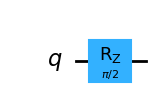

In [50]:
RZ(np.pi / 2).draw(output="mpl")

In [51]:
RZ(np.pi / 2) @ zero_state

RZ([0.70710678-0.70710678j, 0.        +0.j        ])

## $R$ gate

In quantum computing a general $R$ rotation is defined as a combination of $RZ$, $RY$ and $RZ$ gates. This allows us to rotate any state in any direction.

$$R(\theta, \phi, \lambda) |0\rangle = R_Z(\lambda) R_Y(\phi) R_Z(\theta) |0\rangle$$

For example, let's take $\theta=\phi=\lambda=\frac{\pi}{2}$.


In [52]:
R(np.pi / 2, np.pi / 2, np.pi / 2)

R([[ 1.11022302e-16-0.70710678j, -7.07106781e-01+0.j        ],
   [ 7.07106781e-01+0.j        ,  1.11022302e-16+0.70710678j]])

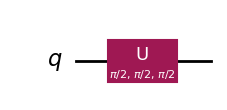

In [53]:
R(np.pi / 2, np.pi / 2, np.pi / 2).draw(output="mpl")

In [54]:
(R(np.pi / 2, np.pi / 2, np.pi / 2) @ zero_state).round(3)

R([0.   -0.707j, 0.707+0.j   ])

$$
R_3\left(\frac{\pi}{2}, \frac{\pi}{2}, \frac{\pi}{2}\right) |0\rangle =
R_Z\left(\frac{\pi}{2}\right)
R_Y\left(\frac{\pi}{2}\right)
R_Z\left(\frac{\pi}{2}\right) |0\rangle = \frac{1}{\sqrt{2}} (-i|0\rangle + |1\rangle).
$$

This gives you a solid background on quantum gates and how they work on quantum states. We also looked at a simple way to represent quantum logic gates in NumPy. In the next lesson we will explore gates for multiple qubits and finally implement real quantum algorithms for multiple qubits. We will work with the [skq](https://github.com/CarloLepelaars/skq) so we have all these gates available and build arbitrary quantum circuits. `skq` will also help us to convert these circuits to other popular frameworks so we can run our quantum algorithms on real quantum computers.

Continue with the next lesson:
- [On Github](https://github.com/CarloLepelaars/q4p/blob/main/nbs/03-multi.ipynb)
- [On Kaggle](https://www.kaggle.com/code/carlolepelaars/q4p-3-multi-qubit-gates-and-algorithms)

-------------------------------------------------

This notebook is part of the [q4p (Quantum Computing for Programmers) series](https://github.com/CarloLepelaars/q4p). The original notebook can be found on [Github](https://github.com/CarloLepelaars/q4p/blob/main/nbs/02-gates.ipynb).

-------------------------------------------------